In [ ]:
'''
【项目09】  中国姓氏排行研究

作业要求
1、数据清洗、整合
要求：
① 将“data01”、“data02”分别读取，并且合并成一个数据
② 结合“户籍地城市编号”及“中国城市代码对照表”数据，将城市经纬度连接进数据中
③ 分别提取“工作地”中的省、市
提示：
① 可以先读取“data01”、“data02”，然后用pd.concat()来连接数据
② 新建字段“工作地-省”，“工作地-市”，“工作地-区县”,如果数据中“工作地”字段无法提取省和市，则用“未识别”填充单元格
   * 通过查看识别后的单元格，如果字数超过5则为“未识别”

2、查看姓氏“普遍指数”，普遍指数=姓氏人口数量
要求：
① 将数据按照“姓”做统计，找到数量最多的TOP20
② 分别制作图表，查看姓氏TOP20的数量及占比
   * 建议用bokeh出柱状图，并且为联动图表
③ 查看“王”姓的全国分布
   * 这里导出excel高版本文件，用powermap查看，绘制密度图
   * 同时可以尝试用echarts绘制空间柱状图来查看
④ 查看“姬”姓的全国分布
   * 这里导出excel高版本文件，用powermap查看，绘制密度图
   * 同时可以尝试用echarts绘制空间柱状图来查看
提示：
① bokeh中绘制联动图表时用gridplot
② powermap需要office2016的excel才会有，并且必须存储xlsx格式
③ powermap中需要通过在“值”中设置“姓的计数”才能正确显示热力图
④ powermap中可以通过“主题”来调节配色风格 / “平面地图”选项来调整球面可视化或者平面可视化
⑤ echarts绘制图表之前，需要对数据按照“lng”（或者“lat”）汇总，得到同一个地点的该姓氏人数，然后绘图
⑥ ecahrts通过设置以下参数来达到效果：视角远近、点柱大小

3、查看姓氏“奔波指数”，奔波指数=姓氏人均迁徙距离。迁徙距离为户籍地所在地级市与现居住地所在地级市的距离。
要求：
① 根据识别的工作地，通过Geocoding查询到对应坐标
② 选择一个姓氏，计算并查看其姓氏的奔波指数，并计算该姓氏的人均通勤距离
   * 在python中筛选数据之后，qgis内做空间分析
③ 按照起点和终点做计数，汇总同一个迁徙路径的数据
④ 通过echart制作通勤OD图
   * 可以将生成的line文件导出geojson，用空间线性轨迹图来表示
   * 这里线的valye为该迁徙路径的汇总计数   
提示：
① 可以筛选一些好玩的姓氏：汤、朴、廉、何、叶、冉等等 
② 需要对数据的工作地进行筛选，其中“工作地_市”、“工作地_区县”未识别的数据删除掉
③ 导出数据时，尽量columns名用全英文，避免qgis中出现乱码
④ 计算人均通勤距离的时候，需要删除掉户籍地与工作地相同的人（未迁移的人）
⑤ 在官网metrodata.cn的小工具中找到geocoding
⑥ qgis中需要安装插件“LinePlotter”来转线，并在qgis中计算平均通勤距离（需要投影，投影经度带可选48）
⑦ shapefile转geojson时：
   * 注意shapefile文件要投影回wgs84地理坐标系
   * 删除乱码子弹
   * 删除路径距离为0的数据


'''

In [19]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.filterwarnings('ignore') 


In [4]:
# 1、数据清洗、整合
# 要求：
# ① 将“data01”、“data02”分别读取，并且合并成一个数据
# ② 结合“户籍地城市编号”及“中国城市代码对照表”数据，将城市经纬度连接进数据中
# ③ 分别提取“工作地”中的省、市
# 提示：
# ① 可以先读取“data01”、“data02”，然后用pd.concat()来连接数据
# ② 新建字段“工作地-省”，“工作地-市”，“工作地-区县”,如果数据中“工作地”字段无法提取省和市，则用“未识别”填充单元格
#    * 通过查看识别后的单元格，如果字数超过5则为“未识别”

data01 = pd.read_csv(r'D:\BaiduNetdiskDownload\项目09中国姓氏排行研究\data01.csv',encoding='utf8')
data02= pd.read_csv(r'D:\BaiduNetdiskDownload\项目09中国姓氏排行研究\data02.csv',encoding='utf8')
data=pd.concat([data01,data02])
city_code = pd.read_excel(r'D:\BaiduNetdiskDownload\项目09中国姓氏排行研究\中国行政代码对照表.xlsx')
city_code['行政编码']=city_code['行政编码'].astype(str)
data_merge = pd.merge(data,city_code,left_on='户籍地城市编号',right_on='行政编码',how='left')
data_merge.drop(['行政编码','户籍地城市编号'],axis=1,inplace=True)

data_merge['工作地-省']= data_merge['工作地'].str.split('省').str[0]
data_merge['工作地-市']=data_merge['工作地'].str.split('省').str[1].str.split('市').str[0]
data_merge.loc[data_merge['工作地-省'].str.len()>5,['工作地-市']]=data_merge['工作地-省'].str.split('市').str[0]
data_merge.head()
data_merge['工作地-区县']=''
data_merge.loc[(data_merge['工作地-市'].str.len()>5)&(data_merge['工作地'].str.contains('区')),['工作地-区县']]=data_merge['工作地'].str.split('区').str[0]+'区'
data_merge.loc[(data_merge['工作地-市'].str.len()>5)&(data_merge['工作地'].str.contains('县')),['工作地-区县']]=data_merge['工作地'].str.split('县').str[0]+'县'
data_merge.loc[(data_merge['工作地-市'].str.len()<5)&(data_merge['工作地'].str.contains('区')),['工作地-区县']]=data_merge['工作地'].str.split('市').\
str[1].str.split('区').str[0]+'区'
data_merge.loc[(data_merge['工作地-市'].str.len()<5)&(data_merge['工作地'].str.contains('县')),['工作地-区县']]=data_merge['工作地'].str.split('市').\
str[1].str.split('县').str[0]+'区'
data_merge.loc[data_merge['工作地-省'].str.len()>5,['工作地-省']]='未识别'
data_merge.loc[data_merge['工作地-市'].str.len()>5,['工作地-市']]='未识别'
data_merge.loc[(data_merge['工作地-区县'].str.len()>5)|(data_merge['工作地-区县'].str.len()<2),['工作地-区县']]='未识别'
data_merge.head(20)

,姓,工作地,省,市,区/县,lng,lat,工作地-省,工作地-市,工作地-区县
0,孙,上海市瑞金二路129弄6号,上海市,上海,徐汇区,121.446235,31.169152,未识别,上海,未识别
1,潘,山东省日照市北京路中段,山东省,烟台,莱州市,120.001344,37.190401,山东,日照,未识别
2,徐,武汉市珞狮南路517号,湖北省,武汉,武昌区,114.353622,30.564860,未识别,武汉,未识别
3,周,上海市普陀区石湾路7弄51号503室,江苏省,南通,崇川区,120.887599,31.962661,未识别,上海,普陀区
4,王,西安市太白南路181号西部电子社区A-A-405,陕西省,西安,莲湖区,108.915547,34.273192,未识别,西安,未识别
5,鲍,杭州市下城区体育场路335号,浙江省,嘉兴,秀城区,-1.000000,-1.000000,未识别,杭州,下城区
6,尹,武川路78弄18楼702,辽宁省,抚顺,清原满族自治县,124.924317,42.118882,未识别,未识别,未识别
7,姚,-亭湖区盐湾村六组88号,江苏省,盐城,亭湖区,120.206351,33.378948,未识别,未识别,-亭湖区
8,张,浙江省慈溪市周巷镇三江口村牛角尖,浙江省,宁波,慈溪市,121.338408,30.189257,浙江,慈溪,未识别
9,王,江苏省淮安市承德北路28号,江苏省,淮安,清浦区,119.025325,33.488642,江苏,淮安,未识别


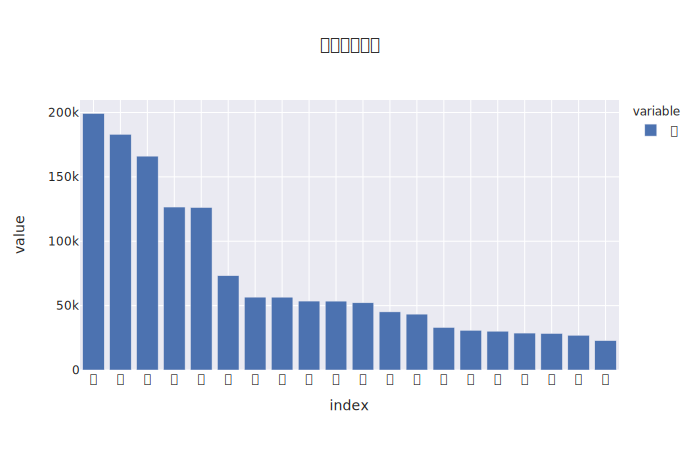

In [29]:
# 2、查看姓氏“普遍指数”，普遍指数=姓氏人口数量
# 要求：
# ① 将数据按照“姓”做统计，找到数量最多的TOP20
# ② 分别制作图表，查看姓氏TOP20的数量及占比
#    * 建议用bokeh出柱状图，并且为联动图表
# ③ 查看“王”姓的全国分布
#    * 这里导出excel高版本文件，用powermap查看，绘制密度图
#    * 同时可以尝试用echarts绘制空间柱状图来查看
# ④ 查看“姬”姓的全国分布
#    * 这里导出excel高版本文件，用powermap查看，绘制密度图
#    * 同时可以尝试用echarts绘制空间柱状图来查看
# 提示：
# ① bokeh中绘制联动图表时用gridplot
# ② powermap需要office2016的excel才会有，并且必须存储xlsx格式
# ③ powermap中需要通过在“值”中设置“姓的计数”才能正确显示热力图
# ④ powermap中可以通过“主题”来调节配色风格 / “平面地图”选项来调整球面可视化或者平面可视化
# ⑤ echarts绘制图表之前，需要对数据按照“lng”（或者“lat”）汇总，得到同一个地点的该姓氏人数，然后绘图
# ⑥ ecahrts通过设置以下参数来达到效果：视角远近、点柱大小

data_name = data_merge['姓'].value_counts(ascending=False)
data_name.head()
fig = px.bar(data_name.iloc[:20],template='seaborn',title='姓氏人口排名')
fig.show(renderer='svg')
# data_name_wang = data_merge[data_merge['姓']=='王']